# Angelo

Search using experimental tabulated phases in DatabaseExp Created using MuzeoEgizio Notebook.

### Imports

In [1]:
from XRDXRFutils import Phase,DatabaseXRD, DataXRD, SpectraXRD, GaussNewton, PhaseList, PhaseMap, PhaseSearch, PhaseMapSave
from XRDXRFutils import GammaMap,ChiMap

import os
import pickle


from joblib import Parallel, delayed
import h5py
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, least_squares

from numpy import linspace,concatenate,sqrt,log,histogram,array
from matplotlib.pyplot import sca,vlines,show,fill_between,sca,legend,imshow,subplots,plot,xlim,ylim,xlabel,ylabel,cm,title,scatter,colorbar,figure,vlines
from sklearn.cluster import KMeans,MiniBatchKMeans

from multiprocessing import Pool

from PIL import Image

def f_linear(x,a,b):
    return a*x + b
def f_loss(x,t,y):
    return (x[0]*t + x[1]) - y

#### Define Paths and Spectra Parameters

In [2]:
path_xrd = '/home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/' # XRD scan
path_xrf = '/home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRF/' # XRF scan
path_database = '/home/shared/DatabaseXRD'

path_data = 'data/' # data of intermediate results, for fast loading
path_figures = 'figures/' # figures generated by the script
path_results = 'results/' # results generated by the script: raw data, tif maps

min_theta = 17
max_theta = 43
min_intensity = 0.1 # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = None # selects the first n most intense peaks (if None, leaves all the peaks)\

sigma = 0.15

## Read XRD Data

from xrd.h5

Loading: /home/shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/xrd.h5
a: -1172.8 s: 2053.1 beta: 50.710


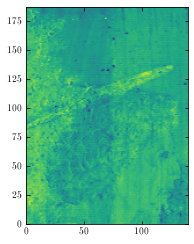

In [3]:
try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5')
except:
    print('Reading from raw data.')
    data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').remove_background(std = 5).save_h5(path_xrd + 'xrd.h5')
    
print("a: %.1f s: %.1f beta: %.3f"%(data.opt[0],data.opt[1],data.opt[2]))

figure(figsize=(6,4))
im = imshow(data.data.sum(axis=2))
show()

## Read database

##### Define Phases
This is for simplification. Phases can be selected iteratively from database using 'Tab'

In [4]:
database = DatabaseXRD().read_cifs(path_database)
databaseExp = DatabaseXRD().read_cifs('AngeloDatabase/')

print('Phases in database:',len(database))
print('Phases in databaseEXP:',len(databaseExp))

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]
gold = database['Gold'][0]

huntite = database['Huntite'][0]
as4 = database['As4 O6'][0]

orpiment = database['Orpiment'][0]
cuprorivaite = database['Cuprorivaite'][0]


hydrocerussite = databaseExp['Hydrocerussite'][0]
cinnabar = databaseExp['Cinnabar'][0]
#lazurite = databaseExp['Lazurite'][0]
gold = databaseExp['Gold'][0]
hematite = databaseExp['Hematite'][0]
#mix = databaseExp['Mix'][0]


phases_a_s = PhaseList([hydrocerussite, cinnabar, lazurite, gold, hematite])

phases_a_s.get_theta(min_intensity=min_intensity,
                 min_theta = min_theta,
                 max_theta = max_theta,
                first_n_peaks = first_n_peaks)

if 'pmax_a' in locals():
    data.opt[0] = pmax_a
    data.opt[1] = pmax_s

Phases in database: 137
Phases in databaseEXP: 6


In [5]:
pme = ChiMap().from_data(data,phases_a_s,sigma = sigma)

In [11]:
%%time
pme = pme.search()

CPU times: user 15.4 s, sys: 5.15 s, total: 20.6 s
Wall time: 19.4 s


In [12]:
L1loss, MSEloss, overlap_area = pme.metrics()

In [15]:
chi = pme.chi()

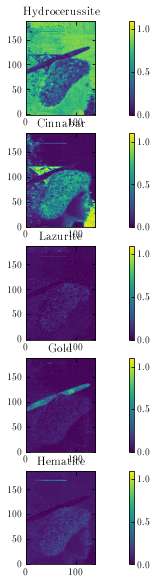

In [16]:
fig,ax = subplots(len(pme.phases),1,figsize=(12,10))

for i,phase in enumerate(pme.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(chi[...,i],vmin=0,vmax=1.1)
    colorbar(p,ax = ax[i])
    
show()

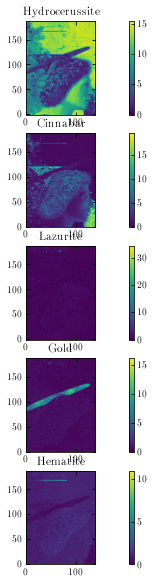

In [20]:
fig,ax = subplots(len(pme.phases),1,figsize=(12,10))

rescaling_chi = pme.chi() * data.rescaling**0.5

for i,phase in enumerate(pme.phases):
    ax[i].set_title(phase.label)
    p = ax[i].imshow(rescaling_chi[...,i],vmin=0)
    colorbar(p,ax = ax[i])
show()

### Histogram of $a$

If $a$ is spead over too large area it might be that the phases are to right or a phase is missing

CPU times: user 114 ms, sys: 1.78 ms, total: 115 ms
Wall time: 114 ms


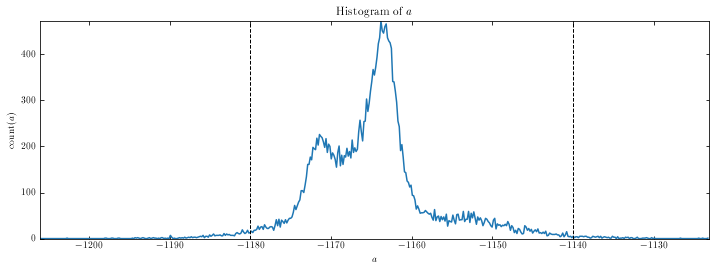

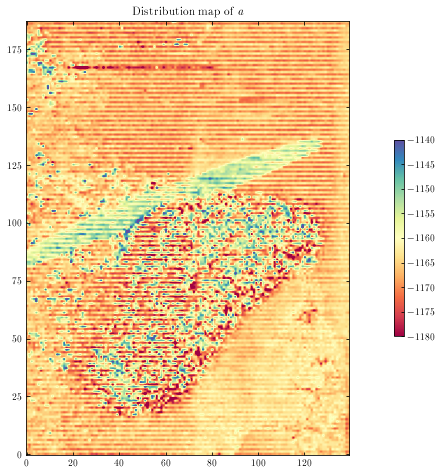

In [21]:
%%time
opt = pme.opt()
a = opt[...,0]
s = opt[...,1]

vmin = -1180
vmax = -1140

h,b = histogram(a,bins=512)

figure(figsize=(12,4))

plot(b[:-1],h)
xlim(b[0],b[-1])
ylim(0,h.max())

vlines(vmin,0,h.max(),'k',ls='--',lw=1)
vlines(vmax,0,h.max(),'k',ls='--',lw=1)

xlabel('$a$')
ylabel(r'count($a$)')
title(r'Histogram of $a$')

figure(figsize=(16,8))
title('Distribution map of $a$')
im = imshow(a,cmap='Spectral',vmin=vmin,vmax=vmax)
colorbar(im,fraction=0.011)

## Plotting the $a,s$ dependence

There is a slight notion of a second $as$ dependence but it is weak.

Linear: [   -2.68209392 -1078.04590092]
Cauchy: [-8.98442069e-01  1.00475323e+03]
-1164.700697112086 2045.7907528273595
-1163.8223166025323 2050.3801626872755


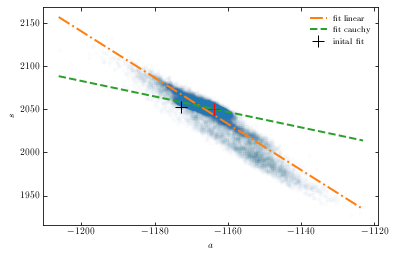

In [22]:
%matplotlib inline

opt,var = curve_fit(f_linear,a.flatten(),s.flatten())
res = least_squares(f_loss,x0=opt,args=(a.flatten(),s.flatten()),loss='cauchy')

linear_y = f_linear(a.flatten(),*opt)
cauchy_y = f_linear(a.flatten(),*res['x'])

print('Linear:',opt)
print('Cauchy:',res['x'])

plot(a.flatten(),s.flatten(),'.',alpha=0.01)

x = linspace(a.min(),a.max(),10)
plot(x,f_linear(x,*opt),'-.',lw=2,label='fit linear')
plot(x,f_linear(x,*res['x']),'--',lw=2,label='fit cauchy')
plot(data.opt[0],data.opt[1],'k+',ms=12,label='inital fit')

print(a.mean(),s.mean())

legend(frameon=False)

xlabel(r'$a$')
ylabel(r'$s$')

pmax_a = b[h.argmax()]
pmax_s = f_linear(pmax_a, *res['x'])

print(pmax_a,pmax_s)

plot(pmax_a,pmax_s,'r+',ms=12,label='most likely')

show()